## Phase 1.1: Setup & Data Acquisition

- **Install dependencies**  
- **Load the True & Fake CSVs from `RawData/`**  
- **Combine into one DataFrame**  
- **Inspect data** 

In [1]:
%pip install --quiet pandas matplotlib seaborn nltk scikit-learn
%pip install --quiet vaderSentiment textstat
%pip install --quiet xgboost
%pip install --quiet transformers datasets torch


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# %pip uninstall -y tensorflow keras tf-keras


In [3]:

%pip install transformers[torch] torch


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip uninstall -y tensorboard


Note: you may need to restart the kernel to use updated packages.


In [5]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer


In [6]:
import torch
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [7]:
import os
import subprocess
import shutil

# --- 1) Ensure RawData folder and original Kaggle files ---
raw_dir = 'RawData'
os.makedirs(raw_dir, exist_ok=True)

true_fp = os.path.join(raw_dir, 'True.csv')
fake_fp = os.path.join(raw_dir, 'Fake.csv')

if not (os.path.exists(true_fp) and os.path.exists(fake_fp)):
    print("Downloading Fake-and-Real News dataset from Kaggle into RawData/ …")
    try:
        # Requires kaggle.json in ~/.kaggle/
        subprocess.run([
            'kaggle', 'datasets', 'download',
            '-d', 'clmentbisaillon/fake-and-real-news',
            '-p', raw_dir, '--unzip'
        ], check=True)
    except Exception as e:
        print("Error downloading from Kaggle. Make sure your kaggle.json is configured:", e)

# --- 2) Ensure data folder and FakeNewsNet minimal CSVs ---
data_dir = 'RawData'
os.makedirs(data_dir, exist_ok=True)

fnn_min_files = [
    'politifact_fake.csv',
    'politifact_real.csv',
    'gossipcop_fake.csv',
    'gossipcop_real.csv'
]
missing = [f for f in fnn_min_files if not os.path.exists(os.path.join(data_dir, f))]

if missing:
    print("Fetching FakeNewsNet minimal dataset from GitHub …")
    repo = 'FakeNewsNet'
    if not os.path.isdir(repo):
        subprocess.run(['git', 'clone', 'https://github.com/KaiDMML/FakeNewsNet.git'], check=False)
    dataset_dir = os.path.join(repo, 'dataset')
    for fname in missing:
        src = os.path.join(dataset_dir, fname)
        dst = os.path.join(data_dir, fname)
        if os.path.exists(src):
            shutil.copy(src, dst)
            print(f"  • Copied {fname} to {data_dir}/")
        else:
            print(f" {fname} not found in {dataset_dir}")
    # shutil.rmtree(repo, ignore_errors=True)

print("All required data files are in place.")


All required data files are in place.


In [8]:
# Load the CSV files from RawData
data_dir = './RawData'
files = [f for f in os.listdir(data_dir) if f.lower().endswith('.csv')]
print("Files found:", files)

# Load and label
trueNews = pd.read_csv(os.path.join(data_dir, 'True.csv'))
fakeNews = pd.read_csv(os.path.join(data_dir, 'Fake.csv'))

trueNews['label'] = 'real'
fakeNews['label'] = 'fake'

# 3) Combine into a single DataFrame
df = pd.concat([trueNews, fakeNews], ignore_index=True)

# 4) Inspect the combined dataset
print(f"Combined shape: {df.shape}\n")
print("Columns:", df.columns.tolist(), "\n")
print("Sample rows:")
display(df.sample(5, random_state=42))

# 5) Check class balance
print("Class distribution:")
print(df['label'].value_counts())


Files found: ['Fake.csv', 'gossipcop_fake.csv', 'gossipcop_real.csv', 'politifact_fake.csv', 'politifact_real.csv', 'True.csv']
Combined shape: (44898, 5)

Columns: ['title', 'text', 'subject', 'date', 'label'] 

Sample rows:


,title,text,subject,date,label
22216,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",fake
27917,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",fake
25007,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",fake
1377,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",real
32476,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",fake


Class distribution:
label
fake    23481
real    21417
Name: count, dtype: int64


## Phase 1.2: Exploratory Data Analysis (EDA)

- **Missing & duplicate checks**  
- **Class distribution by domain (`subject`)**  
- **Text length**: word count & character count  
- **Length comparison** across fake vs. real  
- **Top words** per class  


Missing values per column:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64 

Total duplicate rows: 209 



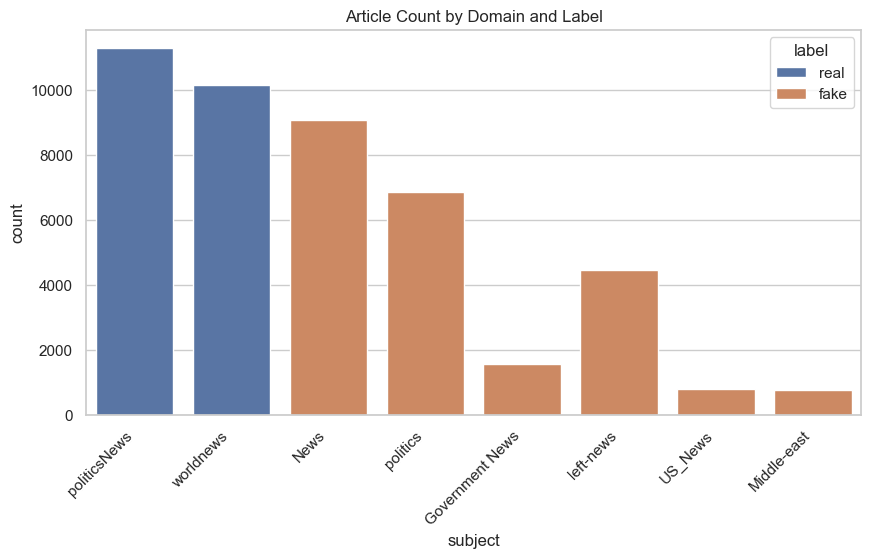

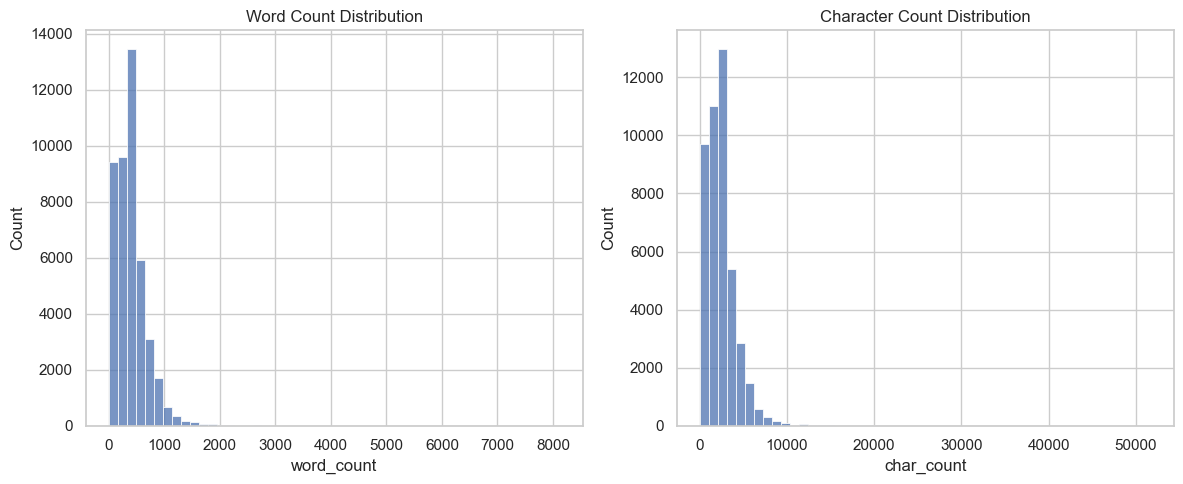

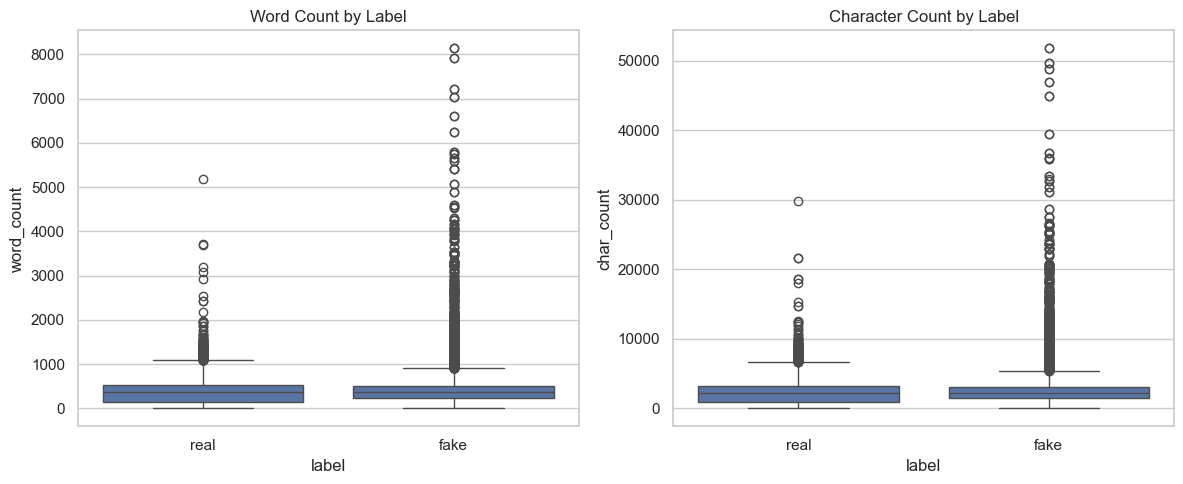

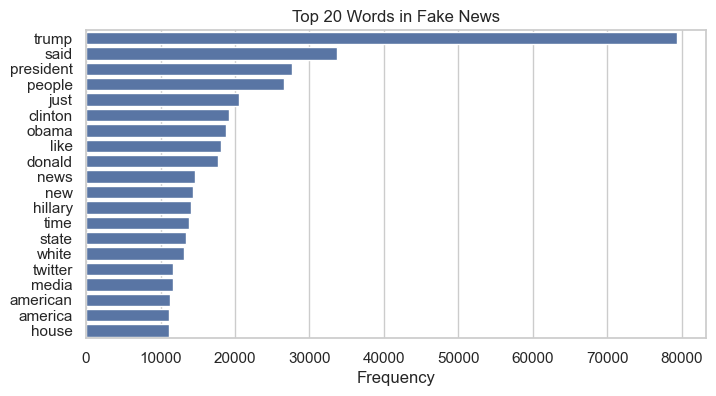

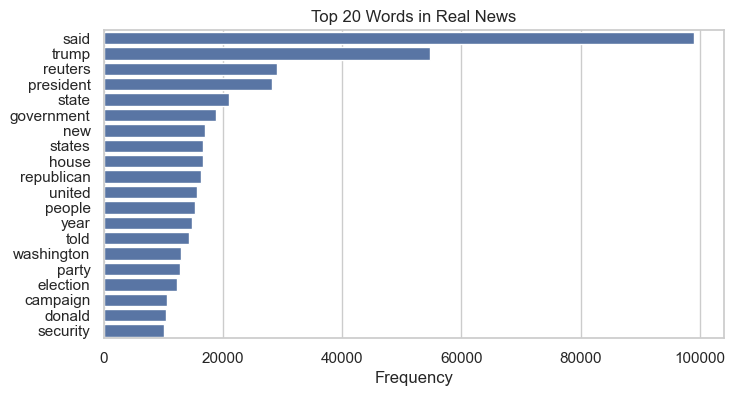

In [9]:

sns.set_theme(style="whitegrid")

# 2) Missing values & duplicates
print("Missing values per column:\n", df.isna().sum(), "\n")
print("Total duplicate rows:", df.duplicated().sum(), "\n")

# 3) Class distribution by subject
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='subject', hue='label')
plt.xticks(rotation=45, ha='right')
plt.title("Article Count by Domain and Label")
plt.show()

# 4) Text length features
# Compute word_count and char_count if not present
if 'word_count' not in df.columns:
    df['word_count'] = df['text'].str.split().str.len()
if 'char_count' not in df.columns:
    df['char_count'] = df['text'].str.len()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df['word_count'], bins=50, ax=axes[0])
axes[0].set_title("Word Count Distribution")
sns.histplot(df['char_count'], bins=50, ax=axes[1])
axes[1].set_title("Character Count Distribution")
plt.tight_layout()
plt.show()

# 5) Length comparison by label
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(data=df, x='label', y='word_count', ax=axes[0])
axes[0].set_title("Word Count by Label")
sns.boxplot(data=df, x='label', y='char_count', ax=axes[1])
axes[1].set_title("Character Count by Label")
plt.tight_layout()
plt.show()

# 6) Top 20 words per class
def plot_top_n_words(texts, n, title):
    vect = CountVectorizer(stop_words='english')
    X = vect.fit_transform(texts)
    sums = X.sum(axis=0).A1
    words = vect.get_feature_names_out()
    top_n = sorted(zip(words, sums), key=lambda x: x[1], reverse=True)[:n]
    words_top, counts_top = zip(*top_n)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(counts_top), y=list(words_top))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.show()

plot_top_n_words(df[df['label']=='fake']['text'], 20, "Top 20 Words in Fake News")
plot_top_n_words(df[df['label']=='real']['text'], 20, "Top 20 Words in Real News")


## Phase 1.3: Data Preprocessing & Feature Engineering

This phase focuses on preparing the dataset for modeling by addressing domain artifacts, normalizing features, and ensuring fair evaluation.

- **Subject Bucketing:**  
  Rare or exclusively fake news domains—such as `Government News`, `left-news`, `US_News`, and `Middle-east`—are grouped into a single `Other` category. This prevents the model from simply memorizing domain–label associations and encourages it to learn from the article content itself.

- **Length Normalization:**  
  Article length features, specifically word and character counts, are log-transformed. This reduces the influence of unusually long articles and helps the model focus on meaningful differences in article size.

- **Text Cleaning:**  
  The article text is standardized by converting to lowercase, removing punctuation, numbers, URLs, and HTML tags, and filtering out non-alphabetic tokens. Common stopwords are removed, and words are lemmatized to their base forms. These steps ensure that the text representation is consistent and less noisy, improving the quality of features extracted later.

- **Categorical Encoding:**  
  The rebucketed subject/domain field is one-hot encoded. This allows the model to use domain information without introducing artificial order or bias.

- **Feature Extraction:**  
  Both rich text features (TF-IDF vectors of unigrams and bigrams) and simple, interpretable features (log-transformed word and character counts) are included. This combination provides the model with a balance of detailed linguistic information and high-level structural cues.

- **Stratified Train/Test Split:**  
  The dataset is split into training and test sets (80/20), ensuring that both label and domain distributions are preserved in each subset. This stratification leads to more reliable and fair evaluation of model performance.

By applying these preprocessing and feature engineering steps, the dataset is made more suitable for machine learning. The approach reduces the risk of overfitting to superficial patterns, such as rare domains or outlier article lengths, and encourages the model to generalize based on genuine differences between fake and real news.


In [10]:
# 2) Subject bucketing
rare = ['Government News','left-news','US_News','Middle-east']
df['subject2'] = df['subject'].apply(lambda s: 'Other' if s in rare else s)

# 3) Log-transform length features
df['log_word_count'] = np.log1p(df['word_count'])
df['log_char_count'] = np.log1p(df['char_count'])

# 4) Text cleaning setup
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r'<.*?>', ' ', txt)               # remove HTML
    txt = re.sub(r'http\S+|www\.\S+', ' ', txt)    # remove URLs
    txt = re.sub(r'[^a-z\s]', ' ', txt)            # keep letters & spaces
    tokens = txt.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens
              if t not in stop_words and len(t)>2]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

# 5) Prepare features & label
X = df[['clean_text','log_word_count','log_char_count','subject2']]
y = df['label']

# 6) Stratified train-test split
df['stratify_col'] = df['label'] + '_' + df['subject2']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df['stratify_col'], random_state=42
)

# 7) Build transformers
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=50000))
])
preprocessor = ColumnTransformer([
    ('text', text_pipe, 'clean_text'),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['subject2']),
    ('num', 'passthrough', ['log_word_count','log_char_count'])
])

# 8) Fit/transform
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Data is now ready for modeling


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Phase 1.4: Baseline Model Without Domain

This phase establishes a baseline for fake news detection using only the article text and basic length features, intentionally excluding any information about the article's domain or subject. By removing domain cues, the model is forced to rely solely on the content and structure of the text, providing a more realistic measure of its ability to generalize beyond superficial dataset artifacts.

**Why exclude domain information?**  
Including domain or subject fields can lead to artificially high performance, as some domains may be perfectly correlated with either fake or real news in the dataset. This creates a risk of data leakage, where the model learns to identify the source rather than the underlying characteristics of fake news. By omitting these fields, the evaluation better reflects the model’s true capability to distinguish fake from real news based on content alone.

**Approach:**  
- The model uses a combination of TF–IDF features extracted from the cleaned article text and two numeric features representing the log-transformed word and character counts.
- A logistic regression classifier is trained on these features, with no access to domain or subject information.
- Performance is assessed using standard classification metrics and a confusion matrix, providing a benchmark for future improvements.

This baseline serves as a reference point for evaluating the impact of more advanced features and domain knowledge in subsequent phases.


=== Overall Classification Report ===
              precision    recall  f1-score   support

        fake     0.9925    0.9832    0.9878      4696
        real     0.9817    0.9918    0.9868      4284

    accuracy                         0.9873      8980
   macro avg     0.9871    0.9875    0.9873      8980
weighted avg     0.9874    0.9873    0.9873      8980



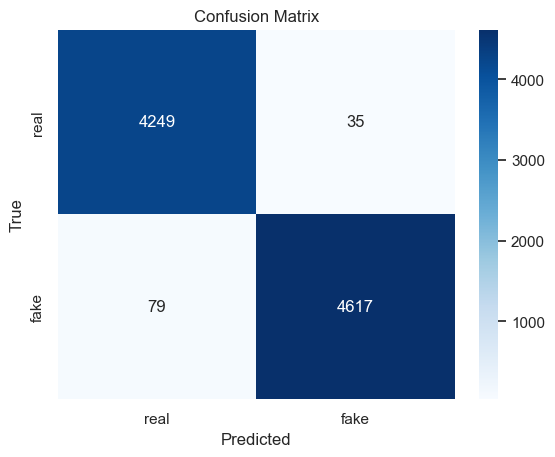

=== Class-wise Classification Report ===
              precision    recall  f1-score   support

        real     0.9925    0.9832    0.9878      4696
        fake     0.9817    0.9918    0.9868      4284

    accuracy                         0.9873      8980
   macro avg     0.9871    0.9875    0.9873      8980
weighted avg     0.9874    0.9873    0.9873      8980



In [11]:
# Preprocessor: use only text and numeric features (no domain info)
preprocessor_text_num = ColumnTransformer([
    ('text', text_pipe, 'clean_text'),
    ('num', 'passthrough', ['log_word_count','log_char_count'])
])

# 2) Full pipeline
baseline_no_domain = Pipeline([
    ('preproc', preprocessor_text_num),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# 3) Train
baseline_no_domain.fit(X_train, y_train)

# 4) Predict
y_pred_nd = baseline_no_domain.predict(X_test)

# 5) Overall Report
print("=== Overall Classification Report ===")
print(classification_report(y_test, y_pred_nd, digits=4))

# 6) Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nd, labels=['real','fake'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['real','fake'], yticklabels=['real','fake'])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()
# 7) Class-wise Report
print("=== Class-wise Classification Report ===")
print(classification_report(y_test, y_pred_nd, target_names=['real','fake'], digits=4))


## Phase 1.5: Feature Importance Analysis

This phase explores which features most strongly influence the model’s predictions of fake versus real news. By examining the largest positive and negative coefficients from the logistic regression, we can identify the words and features that the model relies on most when making its decisions.

Understanding feature importance serves several purposes:
- It reveals which tokens or characteristics are most associated with fake or real news in the dataset.
- It helps detect any spurious signals or dataset artifacts (such as metadata tokens) that may be biasing the model.
- It provides insight into whether the model is learning meaningful distinctions or simply exploiting superficial cues.
- It informs future improvements, such as removing noisy features or adding new, more informative ones.

The analysis involves mapping each model coefficient to its corresponding word or feature, ranking them by their impact, and visualizing the top predictors for both classes. Bar plots and word clouds can be used to illustrate which features are most indicative of fake or real news, making the model’s behavior more transparent and interpretable.


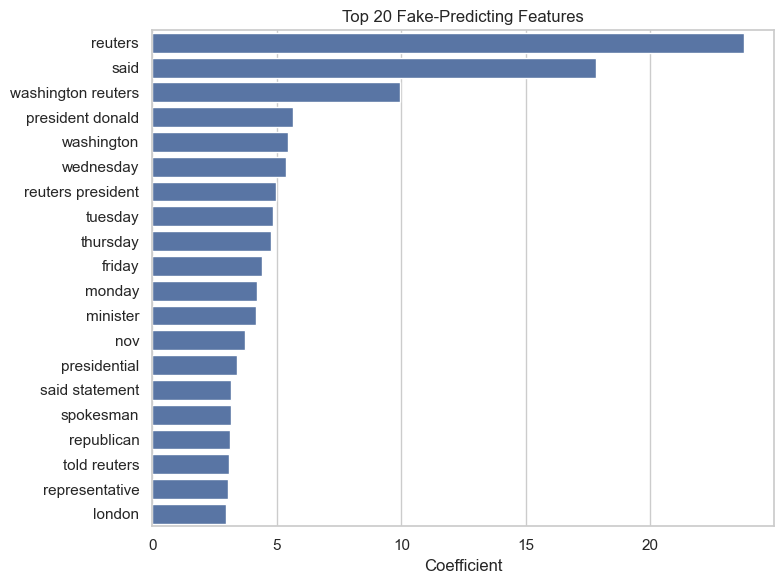

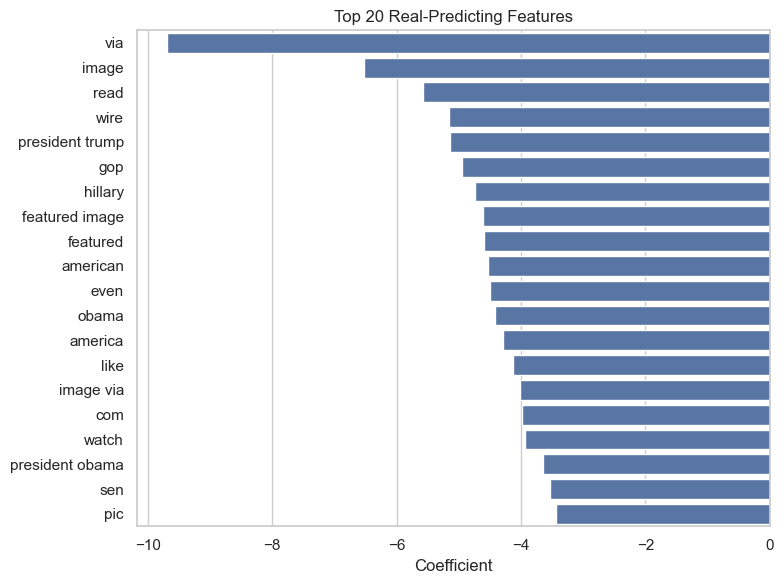

In [12]:
# Get TF-IDF feature names plus numeric feature names
tfidf: TfidfVectorizer = baseline_no_domain.named_steps['preproc'] \
    .named_transformers_['text'] \
    .named_steps['tfidf']
feature_names = tfidf.get_feature_names_out().tolist() + ['log_word_count', 'log_char_count']

# Grab model coefficients
coef = baseline_no_domain.named_steps['clf'].coef_[0]

# Make a DataFrame mapping features to coefficients
import pandas as pd
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'coef': coef
})

# Show top features for fake and real predictions
top_fake = feat_imp.nlargest(20, 'coef')
top_real = feat_imp.nsmallest(20, 'coef')

# Plot the most fake-predicting features
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.barplot(data=top_fake, x='coef', y='feature')
plt.title("Top 20 Fake-Predicting Features")
plt.xlabel("Coefficient")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Plot the most real-predicting features
plt.figure(figsize=(8,6))
sns.barplot(data=top_real, x='coef', y='feature')
plt.title("Top 20 Real-Predicting Features")
plt.xlabel("Coefficient")
plt.ylabel("")
plt.tight_layout()
plt.show()


## Phase 2.1: Advanced Feature Engineering

This phase enhances the feature set to improve model robustness and reduce reliance on superficial cues.

**Metadata Pruning:**  
A set of common metadata tokens and artifacts (such as `reuters`, `said`, weekdays, `via`, `image`, `.com`, etc.) are removed from the cleaned text. This prevents the model from exploiting formatting or source tags that do not reflect genuine content.

**Numeric Features:**  
- `log_word_count` and `log_char_count`: Log-transformed counts to represent article length while minimizing the impact of outliers.
- `vader_compound`: Sentiment polarity score, quantifying the overall emotional tone of the article.
- `flesch_kincaid` and `gunning_fog`: Readability indices, measuring the complexity and grade level of the text.

**Rationale:**  
- Pruning metadata ensures the classifier learns from content-based distinctions rather than dataset artifacts.
- Sentiment and readability features capture stylistic differences that may help distinguish fake from real news.

**Implementation Overview:**  
- A list of metadata tokens is defined and used to filter out these terms from the `clean_text` column, producing a new `pruned_text` column.
- Sentiment and readability features are computed using VADER and TextStat.
- A `ColumnTransformer` is constructed to combine TF–IDF features from `pruned_text` with the numeric features: `log_word_count`, `log_char_count`, `vader_compound`, `flesch_kincaid`, and `gunning_fog`.
- The data is split (stratified by `label_subject2`), transformed, and prepared for modeling.


In [13]:
analyzer = SentimentIntensityAnalyzer()

# Metadata tokens to remove from text (e.g. newswire artifacts)
metadata_terms = {
    'reuters','washington','said','via','image','com','monday','tuesday',
    'wednesday','thursday','friday','saturday','sunday','minister','nov',
    'presidential','statement','spokesman','republican','told','representative',
    'london'
}

# Remove metadata tokens from cleaned text
df['pruned_text'] = df['clean_text'].apply(
    lambda txt: ' '.join([t for t in txt.split() if t not in metadata_terms])
)

# Add sentiment and readability features
df['vader_compound'] = df['text'].apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)
df['flesch_kincaid'] = df['text'].apply(
    lambda x: textstat.flesch_kincaid_grade(x)
)
df['gunning_fog'] = df['text'].apply(
    lambda x: textstat.gunning_fog(x)
)

# Prepare features and label for modeling
X_adv = df[[
    'pruned_text',
    'log_word_count','log_char_count',
    'vader_compound','flesch_kincaid','gunning_fog'
]]
y_adv = df['label']

# Stratified train/test split
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_adv, y_adv,
    test_size=0.2,
    stratify=df['stratify_col'],
    random_state=42
)
# New preprocessor: only text + numeric
tfidf_pruned = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=50000))
])

preprocessor_adv = ColumnTransformer([
    ('text', tfidf_pruned, 'pruned_text'),
    ('num', 'passthrough', [
        'log_word_count','log_char_count',
        'vader_compound','flesch_kincaid','gunning_fog'
    ])
])

# Transform train and test sets
X_train_adv_prep = preprocessor_adv.fit_transform(X_train_adv)
X_test_adv_prep  = preprocessor_adv.transform(X_test_adv)

## Phase 2.1 Modeling: Evaluating Advanced Features

This phase assesses a **Logistic Regression** model trained on the enhanced feature set

**Rationale for Numeric Features:**
- Length features (`log_word_count`, `log_char_count`) help distinguish between short, sensational headlines and longer, in-depth reporting, which often differ between fake and real news.
- Sentiment (`vader_compound`) captures emotional tone, as fake news may use more extreme or polarized language.
- Readability scores (`flesch_kincaid`, `gunning_fog`) reflect writing complexity; real news tends to be more formal and complex, while fake news may target broader audiences with simpler language.

**Evaluation Approach:**
- The model pipeline combines `preprocessor_adv` and `LogisticRegression`.
- Training is performed on the advanced feature set (`X_train_adv`, `y_train_adv`).
- Performance is evaluated on the test set (`X_test_adv`), reporting both the classification report and confusion matrix.
- Results are compared to the previous text-only baseline (F1 ≈ 0.9873) to determine the impact of metadata pruning and the addition of sentiment/readability features.


=== Advanced Features Classification Report ===

              precision    recall  f1-score   support

        fake     0.9794    0.9695    0.9744      4696
        real     0.9670    0.9776    0.9723      4284

    accuracy                         0.9734      8980
   macro avg     0.9732    0.9736    0.9733      8980
weighted avg     0.9735    0.9734    0.9734      8980



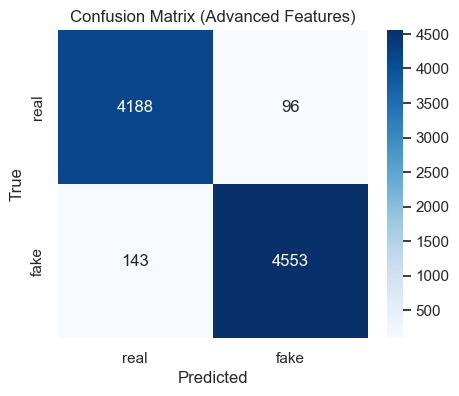

In [14]:
# Build pipeline with advanced features
adv_pipe = Pipeline([
    ('preproc', preprocessor_adv),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Train the model
adv_pipe.fit(X_train_adv, y_train_adv)

# Make predictions
y_pred_adv = adv_pipe.predict(X_test_adv)

# Show classification report
print("=== Advanced Features Classification Report ===\n")
print(classification_report(y_test_adv, y_pred_adv, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test_adv, y_pred_adv, labels=['real','fake'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['real','fake'], yticklabels=['real','fake'])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (Advanced Features)")
plt.show()


### Augmenting the Dataset with FakeNewsNet Titles

- The following files from FakeNewsNet are used:
    - `politifact_fake.csv` (labeled as `fake`)
    - `politifact_real.csv` (labeled as `real`)
    - `gossipcop_fake.csv` (labeled as `fake`)
    - `gossipcop_real.csv` (labeled as `real`)
- Only the article title is used as the text field for these samples.
- The same feature engineering pipeline is applied as for the original dataset:
    - Compute `word_count` and `char_count`
    - Clean the text and remove metadata tokens to produce `pruned_text`
    - Apply log transforms: `log_word_count`, `log_char_count`
    - Extract sentiment and readability features: `vader_compound`, `flesch_kincaid`, `gunning_fog`
- The processed FakeNewsNet records are concatenated with the original Kaggle-derived DataFrame to form `aug_df`.
- The combined dataset is then re-split, transformed, and prepared for retraining.

In [15]:
data_dir = './RawData'
fnn_files = [
    'politifact_fake.csv',
    'politifact_real.csv',
    'gossipcop_fake.csv',
    'gossipcop_real.csv'
]

# Load FakeNewsNet CSVs and use 'title' as text
aux_dfs = []
for fname in fnn_files:
    path = os.path.join(data_dir, fname)
    tmp = pd.read_csv(path)
    tmp = tmp[['title']].rename(columns={'title':'text'})
    tmp['label'] = 'fake' if 'fake' in fname else 'real'
    aux_dfs.append(tmp)

fnn_df = pd.concat(aux_dfs, ignore_index=True)
print("FakeNewsNet minimal loaded:", fnn_df.shape)
print(fnn_df['label'].value_counts())

# Add all features using existing functions/vars
fnn_df['word_count'] = fnn_df['text'].str.split().str.len()
fnn_df['char_count'] = fnn_df['text'].str.len()
fnn_df['clean_text'] = fnn_df['text'].apply(clean_text)
fnn_df['pruned_text'] = fnn_df['clean_text'].apply(
    lambda txt: ' '.join([t for t in txt.split() if t not in metadata_terms])
)
fnn_df['log_word_count'] = np.log1p(fnn_df['word_count'])
fnn_df['log_char_count'] = np.log1p(fnn_df['char_count'])
fnn_df['vader_compound'] = fnn_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
fnn_df['flesch_kincaid'] = fnn_df['text'].apply(lambda x: textstat.flesch_kincaid_grade(x))
fnn_df['gunning_fog']   = fnn_df['text'].apply(lambda x: textstat.gunning_fog(x))

# Combine with main dataset (same columns as X_adv plus label)
orig_cols = [
    'pruned_text',
    'log_word_count','log_char_count',
    'vader_compound','flesch_kincaid','gunning_fog',
    'label'
]
main_features = df[orig_cols].copy()
aux_features  = fnn_df[orig_cols].copy()

aug_df = pd.concat([main_features, aux_features], ignore_index=True)
print("Augmented shape:", aug_df.shape)
print(aug_df['label'].value_counts())

# Train/test split for the augmented set
X_aug = aug_df.drop(columns='label')
y_aug = aug_df['label']
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug, y_aug, test_size=0.2, stratify=y_aug, random_state=42
)

# Transform features with preprocessor_adv
X_train_aug_prep = preprocessor_adv.fit_transform(X_train_aug)
X_test_aug_prep  = preprocessor_adv.transform(X_test_aug)

print("Data ready for retraining on augmented set.")


FakeNewsNet minimal loaded: (23196, 2)
label
real    17441
fake     5755
Name: count, dtype: int64
Augmented shape: (68094, 7)
label
real    38858
fake    29236
Name: count, dtype: int64
Data ready for retraining on augmented set.


## Phase 2.2 Modeling: Retraining on Augmented Data

Evaluate the impact of dataset augmentation by training a Logistic Regression pipeline (using `preprocessor_adv` and `LogisticRegression`) on the combined dataset (`X_train_aug`, `y_train_aug`) and assessing performance on the corresponding test split (`X_test_aug`, `y_test_aug`).

**Rationale:**  
Augmenting the dataset with FakeNewsNet samples increases diversity in writing styles, topics, and publishers, providing a more realistic and challenging benchmark for model generalization. Comparing accuracy and F1 scores to previous baselines (original: ~0.9873, advanced features: ~0.9734) quantifies the effect of this augmentation.

**Methodology:**  
- The same advanced feature pipeline is applied as in previous phases, including metadata-pruned text, sentiment, and readability features.
- The model is trained on the augmented training set and evaluated on the augmented test set.
- Performance is reported using a classification report and confusion matrix.


=== Augmented Data Classification Report ===

              precision    recall  f1-score   support

        fake     0.9141    0.8851    0.8994      5847
        real     0.9156    0.9375    0.9264      7772

    accuracy                         0.9150     13619
   macro avg     0.9149    0.9113    0.9129     13619
weighted avg     0.9150    0.9150    0.9148     13619



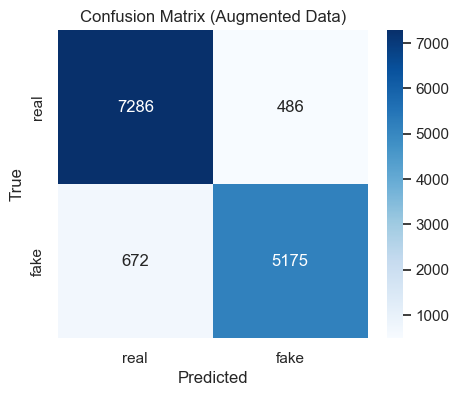

In [16]:
# Build pipeline with advanced preprocessor and logistic regression
aug_pipe = Pipeline([
    ('preproc', preprocessor_adv),
    ('clf', LogisticRegression(max_iter=1000,
                               class_weight='balanced',
                               random_state=42))
])

# Train on the augmented dataset
aug_pipe.fit(X_train_aug, y_train_aug)

# Predict on the test split
y_pred_aug = aug_pipe.predict(X_test_aug)

# Show classification report
print("=== Augmented Data Classification Report ===\n")
print(classification_report(y_test_aug, y_pred_aug, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test_aug, y_pred_aug, labels=['real','fake'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['real','fake'], yticklabels=['real','fake'])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (Augmented Data)")
plt.show()


## Reflection on Augmented Dataset & Performance Drop

- **Richer, More Diverse Data**  
    Integrating FakeNewsNet (Politifact & GossipCop samples) exposes the model to a broader range of writing styles, article lengths, and publishers, extending beyond the original Kaggle newswire-style articles.

- **Metadata Pruning Removes “Cheats”**  
    Formatting and attribution tokens (such as `reuters`, `via`, weekdays, `.com`) are stripped from the text, preventing the classifier from relying on superficial cues and encouraging learning from genuine content and stylistic features.

- **Realistic Evaluation vs. Inflated Scores**  
    The baseline model trained on Kaggle data with metadata achieved an F1 score close to 0.99. When evaluated on the leakage-free, augmented dataset, the F1 score drops to approximately 0.91.  
    - This decline is both expected and desirable, as it reflects true generalization performance rather than overfitting to dataset artifacts.

- **Next Steps**  
    The next phase will involve exploring stronger model architectures and hyperparameter tuning (Phase 2.3) to improve performance on this more robust, real-world dataset.


## Phase 2.3: Model Architecture Exploration — XGBoost

This phase investigates whether a more powerful model architecture, specifically **XGBoost**, can improve fake news detection on the augmented, artifact-pruned dataset.

**Why XGBoost?**  
XGBoost is a gradient-boosted decision tree algorithm known for its ability to capture complex, non-linear relationships in data. Unlike linear models, it can model subtle interactions between features—such as combinations of words, sentiment, and readability—that may signal fake or real news. Its robustness and scalability make it a strong candidate for challenging, high-dimensional text classification tasks.

**Approach Overview:**  
- The advanced, leakage-free feature set (including pruned text, sentiment, and readability) is used as input.
- An XGBoost classifier is trained using the same pipeline structure as previous models, ensuring a fair comparison.
- Model performance is evaluated not only with standard classification metrics (precision, recall, F1, confusion matrix), but also with ROC AUC, which measures the model’s ability to rank predictions by confidence.

By comparing XGBoost’s results to those of logistic regression, this phase assesses whether more sophisticated modeling can recover some of the performance lost when moving to a more realistic, diverse dataset. The goal is to determine if advanced architectures can better generalize and identify fake news without relying on superficial dataset artifacts.


In [17]:
# Encode labels: 1 for 'fake', 0 for 'real'
y_train_aug_encoded = (y_train_aug == 'fake').astype(int)
y_test_aug_encoded = (y_test_aug == 'fake').astype(int)

# Build and train XGBoost pipeline
xgb_pipe = Pipeline([
    ('preproc', preprocessor_adv),
    ('clf', XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42))
])

xgb_pipe.fit(X_train_aug, y_train_aug_encoded)

# Predict on test set
y_pred_xgb_encoded = xgb_pipe.predict(X_test_aug)
# Convert predictions back to string labels
y_pred_xgb = np.where(y_pred_xgb_encoded == 1, 'fake', 'real')
# Get probability for 'fake' class
y_proba_xgb = xgb_pipe.predict_proba(X_test_aug)[:, 1]


C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost Classification Report ===

              precision    recall  f1-score   support

        fake     0.9633    0.8387    0.8967      5847
        real     0.8894    0.9759    0.9307      7772

    accuracy                         0.9170     13619
   macro avg     0.9263    0.9073    0.9137     13619
weighted avg     0.9211    0.9170    0.9161     13619



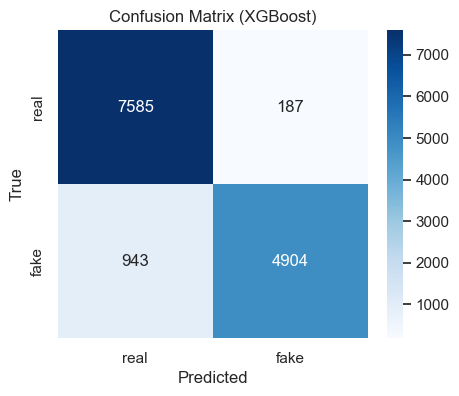

ROC AUC (fake class): 0.9739


In [18]:
# Show XGBoost classification metrics
print("=== XGBoost Classification Report ===\n")
print(classification_report(y_test_aug, y_pred_xgb, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test_aug, y_pred_xgb, labels=['real','fake'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['real','fake'], yticklabels=['real','fake'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# Print ROC AUC score
auc = roc_auc_score(y_test_aug_encoded, y_proba_xgb)
print(f"ROC AUC (fake class): {auc:.4f}")


## Phase 2.3b: Transformer-Based Classifier

This phase introduces a transformer-based approach to fake news detection, leveraging the DistilBERT model to classify news articles as fake or real. Unlike traditional models that rely on hand-crafted features or bag-of-words representations, transformer models are pre-trained on vast amounts of text and can capture subtle linguistic patterns, context, and meaning within the text.

### Motivation

Transformer models, such as DistilBERT, have demonstrated state-of-the-art performance on a wide range of natural language processing tasks, including text classification. By using a pre-trained transformer, the classifier can recognize nuanced cues in language that simpler models may overlook. This is particularly valuable for fake news detection, where differences between real and fake articles can be subtle and context-dependent.

### Approach

The classifier is trained using the "pruned_text" field from the augmented dataset, which has been carefully cleaned to remove metadata and potential sources of data leakage. Only the content of the article is used, ensuring that the model learns to distinguish fake from real news based on genuine linguistic and stylistic features.

The process involves several key steps:
- The dataset is converted into a format compatible with the HuggingFace Transformers library, allowing efficient batching and tokenization.
- Each article's text is tokenized using the DistilBERT tokenizer, which splits the text into subword units and prepares it for input to the model. Texts are truncated or padded to a fixed maximum length to ensure consistent input size.
- The DistilBERT model is fine-tuned for binary classification, adapting its pre-trained language understanding to the specific task of fake news detection.
- Training is performed using standard optimization techniques, with hyperparameters such as batch size, learning rate, and number of epochs chosen to balance accuracy and efficiency.
- Model performance is evaluated on a held-out test set, using metrics such as accuracy, F1 score, and ROC AUC to provide a comprehensive assessment.

### Benefits

By applying a transformer-based model to the pruned, augmented dataset, this phase aims to achieve more robust and generalizable fake news detection. The approach reduces reliance on superficial cues and instead focuses on the deeper linguistic characteristics that distinguish real journalism from fabricated stories. This provides a more realistic benchmark for model performance and helps ensure that the classifier can adapt to new, unseen data in real-world scenarios.

In [19]:
import torch
assert torch.cuda.is_available() or torch.__version__  # verifies PyTorch import

In [21]:
from sklearn.metrics import accuracy_score
os.environ["USE_TF"] = "0"

# Build HuggingFace Dataset objects
#   We only need the text and label columns
train_df = X_train_aug.copy()
train_df['label'] = y_train_aug.values
test_df  = X_test_aug.copy()
test_df['label']  = y_test_aug.values

hf_train = Dataset.from_pandas(train_df[['pruned_text','label']])
hf_test  = Dataset.from_pandas(test_df[['pruned_text','label']])

# 4) Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_fn(batch):
    return tokenizer(
        batch['pruned_text'], 
        padding='max_length', 
        truncation=True, 
        max_length=256
    )

hf_train = hf_train.map(tokenize_fn, batched=True)
hf_test  = hf_test.map(tokenize_fn, batched=True)

# Convert labels to ints
label2id = {'real': 0, 'fake': 1}
hf_train = hf_train.map(lambda x: {'labels': label2id[x['label']]})
hf_test  = hf_test.map(lambda x: {'labels': label2id[x['label']]})

# Set format for PyTorch
hf_train.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
hf_test .set_format(type='torch', columns=['input_ids','attention_mask','labels'])

# Load model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

# # Training arguments
# training_args = TrainingArguments(
#     output_dir='./distilbert-fake-news',
#     evaluation_strategy='epoch',
#     save_strategy='no',
#     logging_strategy='epoch',
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     num_train_epochs=3,
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     load_best_model_at_end=False
# )

# Metrics function
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', pos_label=1
    )
    return {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1}

# # Trainer

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=hf_train,
#     eval_dataset=hf_test,
#     compute_metrics=compute_metrics,
#     callbacks=[]    # ← no TensorBoard / default callbacks
# )

# # 11) Train & Evaluate
# trainer.train()
# results = trainer.evaluate()
# print("\n🚀 Transformer Results:", results)


Map:   0%|          | 0/54475 [00:00<?, ? examples/s]

Map:   0%|          | 0/13619 [00:00<?, ? examples/s]

Map:   0%|          | 0/54475 [00:00<?, ? examples/s]

Map:   0%|          | 0/13619 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Speeding Up Transformer Fine-Tuning

Fine-tuning large transformer models like DistilBERT on a full, augmented fake news dataset can be very time-consuming, especially when using longer text sequences or running on a CPU. Several strategies can be applied to make this process more efficient:

- **Freezing the Base Model:**  
   By keeping the main DistilBERT layers fixed and only training the final classification head, the number of trainable parameters is drastically reduced. This approach speeds up training and is often sufficient for adapting the model to a new classification task.

- **Reducing Sequence Length:**  
   Shortening the maximum number of tokens processed for each article decreases the computational workload. Since many news headlines and short articles do not require long sequences, this adjustment can be made with minimal impact on accuracy.

- **Limiting the Number of Epochs:**  
   Training for fewer epochs—such as one or two—can be enough to achieve good performance, particularly when the dataset is large and the model is already pre-trained on general language tasks.

- **Using Mixed Precision:**  
   When a GPU is available, enabling mixed-precision training (using 16-bit floating point numbers) can accelerate computations and reduce memory usage, allowing for larger batch sizes and faster training.

- **Subsampling the Training Data:**  
   For rapid experimentation or prototyping, a random subset of the training data (5k to 10k samples) can be used. This allows for much quicker model iterations and testing of different configurations before scaling up to the full dataset.

By applying these techniques, it is possible to significantly reduce the time and resources required for transformer fine-tuning, making it more practical to experiment and iterate on model improvements.


In [22]:
# Freeze all DistilBERT layers
for param in model.distilbert.parameters():
    param.requires_grad = False

# Create a smaller train split for fast prototyping (optional)
hf_train_small = hf_train
# .shuffle(seed=42).select(range(5000))

# Update TrainingArguments
training_args = TrainingArguments(
    output_dir='./distilbert-fake-news-fast',
    evaluation_strategy='no',        # skip intermediate eval to save time
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=1,              # single epoch
    learning_rate=2e-5,
    fp16=True,                       # mixed precision (GPU only)
    max_steps=2000,                  # or set a hard limit on steps
    logging_steps=500,
    save_steps=1000,
    disable_tqdm=False
)

# Re-build Trainer without TF callbacks
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_small,    # or hf_train for full
    eval_dataset=hf_test,
    compute_metrics=compute_metrics,
    callbacks=[]                     # disables TensorBoard callback
)

# 5) Fine-tune
trainer.train()
results = trainer.evaluate()
print(results)


C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
2025/07/02 18:23:33 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id c672b637cb7240b492c77ea4f49ae973: Failed to log run data: Exception: Changing param values is not allowed. Param with key='logging_dir' was already logged with value='./distilbert-fake-news\runs\Jul02_17-34-01_SiriusVader' for run ID='c672b637cb7240b492c77ea4f49ae973'. Attempted logging new value './distilbert-fake-news-fast\runs\Jul02_18-23-32_SiriusVader'.
2025/07/02 18:23:34 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id c672b637cb7240b492c77ea4f49ae973: Failed to log run data: Exception: Changing param values is not allowed. Param with key='output_dir' was already logged with value='./distilbert-fake-news' for run ID='c672b637cb7240b492c77ea4f4

Step,Training Loss
500,0.581600
1000,0.474500
1500,0.433700
2000,0.424800


{'eval_loss': 0.41188421845436096, 'eval_accuracy': 0.8218665100227623, 'eval_precision': 0.8790161754930201, 'eval_recall': 0.6784675902172054, 'eval_f1': 0.7658301158301158, 'eval_runtime': 929.2423, 'eval_samples_per_second': 14.656, 'eval_steps_per_second': 0.229, 'epoch': 1.1743981209630066}


## Final Model Selection: XGBoost

The final model chosen for fake news detection is an XGBoost classifier that uses a combination of text-based and numeric features. These features include TF–IDF representations of the article text, as well as measures of article length, sentiment, and readability. 

**Performance Overview:**  
- The model achieves an accuracy of approximately 91.7%.  
- For articles labeled as "fake," the F1 score is about 0.90, indicating a strong balance between precision and recall for this class.  
- For "real" news, the F1 score is around 0.93.  
- The ROC AUC score is approximately 0.97, reflecting the model’s ability to distinguish between fake and real news across different thresholds.

**Reasons for Model Selection:**  
XGBoost was selected because it is able to capture complex patterns in the data that simpler models might miss. Its tree-based approach allows it to recognize subtle combinations of words and numeric features that are often present in fake news. Compared to logistic regression, XGBoost demonstrated improved recall for fake news articles, meaning it was better at identifying these harder-to-detect cases. Additionally, XGBoost trains quickly and provides tools for understanding which features are most important in its decisions, making it both efficient and interpretable.

**Future Directions:**  
To further improve results, the next steps could include adjusting the model’s settings, such as the learning rate and tree depth, to find the best possible configuration. There is also potential to combine XGBoost with other models, such as logistic regression or lightweight transformer-based classifiers, to create an ensemble that benefits from the strengths of each approach. This could lead to even more robust and reliable fake news detection.
